Copyright **`(c)`** Laura Amoroso


# LAB10

Use reinforcement learning to devise a tic-tac-toe player.

### Deadlines:

* Submission: 25/12 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: 06/01 ([CET](https://en.wikipedia.org/wiki/Sol_Invictus))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

By using the "Magic Board" to represent the problem the goal becomes picking 3 numbers whose sum is 15.

In [111]:
from itertools import combinations
from collections import namedtuple, defaultdict
from random import choice, random, randint
from copy import deepcopy
from tqdm.auto import tqdm
import numpy as np

The state is represented by a tuple that contains the positions taken by the 2 players

In [112]:
State= namedtuple('State',['x','o'])

In [113]:
MAGIC=[2,7,6,
       9,5,1,
       4,3,8]

In [114]:
def win(elements):
    """ Checks if elements is winning"""
    return any(sum(c)==15 for c in combinations(elements,3))

def state_value(pos:State):
    """Evaluate position: +1 first player wins"""
    if win(pos.x):
        return 1
    elif win(pos.o):
        return -1
    else:
        return 0

In [115]:
def print_board(pos):
    """ Nicely prints the board"""
    for r in range(3):
        for c in range(3):
            index=r*3+c
            if MAGIC[index] in pos.x:
                print('X', end='')
            elif MAGIC[index] in pos.o:
                print('O', end='')
            else:
                print('-', end='')
        print("\n")

print("\n")

Here a random player, that chooses his moves randomly among the available ones, is defined to play aganist my trained agent.

In [116]:
class RandomPlayer:
    def __init__(self, symbol) -> None:
        self._symbol=symbol
        
    @property
    def symbol(self)-> int:
        return self._symbol
    
    def move(self,available_moves, state=None):
        return choice(list(available_moves))

# Q-LEARNING

I defined an agent that is trained with the Q Learning algorithm. The q table contains the states and the possible moves associated with a value indicating the most promising move. This is represented by an annidated dictionary whose keys are the states and the value is another dictionary that has as keys the actions and as values their qvalues.

At each move the agent receives a reward of 0.1 if the action is among the available ones, -5 if it is not, and at the end of the game +1 for a victory, -1 for a lose and 0 for a tie. The formula I used for updating the table is:

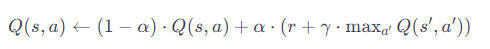


where α is the learning rate, r is the reward obatained by making the action a in the state s, γ is the discount rate  and  is the maximum value of the next state.

α and γ are tuned during the episodes. WIth a certain probability, the exploration rate, the agent does random moves to explore new states. This value is high during the first 1000 episodes and then decreases as suggested in one of the linked papers.  

In [117]:

class QLearningAgent:
    def __init__(self, symbol):
        self.q_table = {}
        self.symbol=symbol
        self._winning_games=0
        self._drawn_games=0
        self.exploration_rate=0.3
        self.alpha=0.7
        self.gamma=0.9
        self.is_train=True


    def move(self, available_moves, state)-> int:
        """    
        if self.exploration_rate>0.01:
            self.exploration_rate*=0.99
        """
        if self.alpha>0.1:
            self.alpha*=0.99

        if self.gamma<0.99:
            self.gamma*=1.01

        state_key = (frozenset(state.x), frozenset(state.o))

        if random() < self.exploration_rate:
          
            action = choice(list(available_moves))
        else:

            if state_key not in self.q_table:
                self.q_table[state_key] = dict.fromkeys(range(1,10), 0)
                
            action = max(self.q_table[state_key], key=self.q_table[state_key].get)

        if self.is_train:
            self.update_q_table(action, available_moves, state)
       
        if action not in available_moves:
            # if the move wasn't available choose a random one
            action=choice(list(available_moves))

            if state_key not in self.q_table:
                self.q_table[state_key] = dict.fromkeys([action], 0)
            return action
            
        return action

    def add_winning(self):
        self._winning_games+=1
        
    def add_drawn(self):
        self._drawn_games+=1

    def update_q_table(self, action, available_moves, state, reward=None):
        #print("updating")
        state_key=(frozenset(state.x), frozenset(state.o))
        if reward is None:

            if action not in available_moves:
                reward=-5
                
            else:
                reward=0.1
                
        if state_key not in self.q_table:
            self.q_table[state_key] = dict.fromkeys([action], 0)

        new_state = deepcopy(state)
        new_state.x.add(action)
        next_state_key = (frozenset(new_state.x), frozenset(new_state.o))

        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = dict.fromkeys(range(1,10), 0)

        self.q_table[state_key][action] = (1 - self.alpha) * self.q_table[state_key].get(action, 0) + self.alpha * (reward + self.gamma * (max(self.q_table[next_state_key].values(), default=0)))


In [118]:

def game(p1,p2, index):
    
    trajectory=list()
    state=State(set(), set())
    available=set(range(1,9+1))
    
    players=[p1,p2]

    while True:
    
        current_player=players[index]

        move=current_player.move(list(available),state)
        trajectory.append((deepcopy(state), move))
        available.remove(move)
        
        if(current_player.symbol == -1):
            state.o.add(move)
            if(win(state.o)) or not available:
                break
        
        else:
            state.x.add(move)
            if(win(state.x)) or not available:
                break
        last_index=index
        index=1-index

    # i compute the final reward
        
    final_reward=state_value(state)

    return trajectory, final_reward
    

The agent always plays with the X symbol and I train it by doing 100_000 iterations in which he starts the game and other 100_000 in which he plays as second.

In [119]:
#o
p1=RandomPlayer(-1)
#x
p2=QLearningAgent(1)

In [120]:
def train(p1,p2, index):


      num_iterations=100_000
      p2._winning_games=0
      p2._drawn_games=0

      for episodes in tqdm(range(num_iterations)):

            # I used the update of the exploration rate suggested in the paper:
            # https://www.researchgate.net/publication/369096697_Reinforcement_Learning_Playing_Tic-Tac-Toe
            
            if episodes>1000 and p2.exploration_rate>0.01:
                  p2.exploration_rate=((1-p2.exploration_rate)*10)/episodes

                  
            trajectory, final_reward=game(p1,p2,index)

            if final_reward ==0:
                  p2.add_drawn()
            elif final_reward==1:
                  p2.add_winning()

            if final_reward == -1:
            
                  s=trajectory[-2][0]
                  a=trajectory[-2][1]

            else:  
                  s=trajectory[-1][0]
                  a=trajectory[-1][1]   
                  

            p2.update_q_table(a,(),s,final_reward)
            

      if index==0:
            print("RANDOM STARTS")
      else:
            print("Q AGENT STARTS")
      print("Winning percentage of the agent ",p2._winning_games/num_iterations*100)
      print("Drawn percentage of the agent ",p2._drawn_games/num_iterations*100)

train(p1,p2,1)
train(p1,p2,0)

  1%|          | 878/100000 [00:00<01:41, 975.19it/s] 

100%|██████████| 100000/100000 [01:14<00:00, 1339.14it/s]


Q AGENT STARTS
Winning percentage of the agent  79.85900000000001
Drawn percentage of the agent  16.006


100%|██████████| 100000/100000 [01:09<00:00, 1445.69it/s]

RANDOM STARTS
Winning percentage of the agent  52.054
Drawn percentage of the agent  32.072


In [121]:
def test(p1,p2, index):
    
    global count_winning
    global count_losing
    global count_tie
    
    state=State(set(), set())
    available=set(range(1,9+1))
    
    players=[p1,p2]
    

    while True:
    
        current_player=players[index]
        move=current_player.move(list(available),state)
      
        if(current_player.symbol == -1):
            state.o.add(move)
            available.remove(move) 
            if(win(state.o)) or not available:
                if (win(state.o)):
                    count_losing+=1
                else: 
                    count_tie+=1
                break
        
        else:
            state.x.add(move)
            available.remove(move) 
            if(win(state.x)) or not available:
                if(win(state.x)):
                    count_winning+=1
                else:
                    count_tie+=1

                break
                
        index=1-index
    return


count_winning=0
count_losing=0
count_tie=0
num_iterations=5000

# when not in train mode the Q table is not updated
p2.is_train=False


for _ in tqdm(range(num_iterations)):
    test(p1,p2,0)

print("RANDOM STARTS")
    
print("winning or tie", (count_winning+count_tie)/num_iterations*100,"%")
print("losing ", count_losing/num_iterations*100,"%")


count_winning=0
count_losing=0
count_tie=0


for _ in tqdm(range(num_iterations)):
    test(p1,p2,1)
    
print("Q AGENT STARTS")

print("winning or tie", (count_winning+count_tie)/num_iterations*100,"%")
print("losing ", count_losing/num_iterations*100,"%")



 30%|███       | 1523/5000 [00:00<00:00, 15086.60it/s]

100%|██████████| 5000/5000 [00:00<00:00, 13551.92it/s]


RANDOM STARTS
winning or tie 83.89999999999999 %
losing  16.1 %


100%|██████████| 5000/5000 [00:00<00:00, 14367.77it/s]

Q AGENT STARTS
winning or tie 97.2 %
losing  2.8000000000000003 %


In [ ]:
""" 
for c,v in p2.q_table.items():
    print(c,v) """

# MONTECARLO 

For the montecarlo agent I chose the same design but I propagate the reward only at the end of the game to all the state visited during the game. This is the formula I use for updating

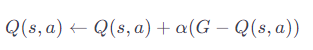

where α is the learning rate and G is the final reward obtained at the end of the game.

I tried to use the sum of the move rewards obtained during the whole game instead of just the final one, but it gave me worse performances. Here I use a reward of 0.1 for the acceptable moves and -0.1 for the unacceptable ones. I also use a different technique to update the exploration rate, because the previous one does not work well since I do less iterations. 

In [123]:

class MontecarloAgent:
    def __init__(self, symbol):
        self.q_table = {}
        self.symbol=symbol
        self._winning_games=0
        self._drawn_games=0
        self.exploration_rate=0.1
        self.rewards=[]
        self.gamma=0.9
        self.is_train=True


    def move(self, available_moves, state)-> int:
        
        if self.exploration_rate>0.01:
            self.exploration_rate*=0.99
        

        if self.gamma<0.99:
            self.gamma*=1.01

        state_key = (frozenset(state.x), frozenset(state.o))

        if random() < self.exploration_rate:
            # sometimes make random moves
            action = choice(list(available_moves))
        else:
            if state_key not in self.q_table:
                self.q_table[state_key] = dict.fromkeys(range(1,10), 0)
            
            #choose the action based on the q table   
            action = max(self.q_table[state_key], key=self.q_table[state_key].get)


        if action not in available_moves:
            reward=-0.1
            
        else:
            reward=0.1
            
        self.rewards.append(reward)
        if action not in available_moves:
            action=choice(list(available_moves))
            
            if state_key not in self.q_table:
                self.q_table[state_key] = dict.fromkeys([action], 0)
            return action
            
        return action

    def add_winning(self):
        self._winning_games+=1
        
    def add_drawn(self):
        self._drawn_games+=1



In [125]:
def train_montecarlo(p1,p2, index):

    num_iterations=100_000
    p2._winning_games=0
    p2._drawn_games=0

    for episodes in tqdm(range(num_iterations)):

        #p2.rewards=[]
        trajectory, final_reward=game(p1,p2,index)

        if final_reward ==0:
                p2.add_drawn()
        elif final_reward==1:
                p2.add_winning()

        for state,action in trajectory:
            if (frozenset(state.x), frozenset(state.o)) in p2.q_table:
                p2.q_table[(frozenset(state.x), frozenset(state.o))][action]+=0.001 * (final_reward -  p2.q_table[(frozenset(state.x), frozenset(state.o))][action])
                
    print("Winning percentage of the agent ",p2._winning_games/num_iterations*100) 
    print("Tie percentage ",p2._drawn_games/num_iterations*100 )
    print("win and ties",(p2._winning_games+p2._drawn_games)/num_iterations*100 )

            
def test_montecarlo(p1,p2, index):
    
    global count_winning
    global count_losing
    global count_tie

    state=State(set(), set())
    available=set(range(1,9+1))
    
    players=[p1,p2]
    

    while True:
    
        current_player=players[index]

        move=current_player.move(list(available),state)
    
        if(current_player.symbol == -1):
            state.o.add(move)
            available.remove(move) 
            if(win(state.o)) or not available:
                if (win(state.o)):
                    count_losing+=1
                else: 
                    count_tie+=1
                break
        
        else:
            state.x.add(move)
            available.remove(move) 
            if(win(state.x)) or not available:
                if(win(state.x)):
                    count_winning+=1
                else:
                    count_tie+=1

                break
                
        index=1-index
    return


#o
p1=RandomPlayer(-1)
#x
p2=MontecarloAgent(1)

print("--------------TRAIN----------------")

print("RANDOM STARTS")
train_montecarlo(p1,p2,0)
print("MONTECARLO AGENT STARTS")
train_montecarlo(p1,p2,1)


print("--------------TEST----------------")
count_winning=0
count_losing=0
count_tie=0

num_iterations=10000
for _ in tqdm(range(num_iterations)):
    test_montecarlo(p1,p2,0)

print("RANDOM STARTS")
    
print("winning or tie", (count_winning+count_tie)/num_iterations*100,"%")
print("losing ", count_losing/num_iterations*100,"%")


count_winning=0
count_losing=0
count_tie=0


for _ in tqdm(range(num_iterations)):
    test_montecarlo(p1,p2,1)

print("MONTECARLO AGENT STARTS")

print("winning or tie", (count_winning+count_tie)/num_iterations*100,"%")
print("losing ", count_losing/num_iterations*100,"%")




--------------TRAIN----------------
RANDOM STARTS


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:43<00:00, 2320.87it/s]


Winning percentage of the agent  78.682
Tie percentage  7.154000000000001
win and ties 85.836
MONTECARLO AGENT STARTS


100%|██████████| 100000/100000 [00:47<00:00, 2087.73it/s]


Winning percentage of the agent  87.258
Tie percentage  6.031000000000001
win and ties 93.289
--------------TEST----------------


100%|██████████| 10000/10000 [00:00<00:00, 15849.05it/s]


RANDOM STARTS
winning or tie 86.63 %
losing  13.370000000000001 %


100%|██████████| 10000/10000 [00:00<00:00, 15624.93it/s]

MONTECARLO AGENT STARTS
winning or tie 93.46 %
losing  6.54 %
